In [3]:
!pip install nltk


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models import LdaModel
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd

In [5]:
import requests
import pandas as pd
import time

def import_data(start_year, end_year, search_terms, max_pages=50, per_page=10):
    all_data = pd.DataFrame()
    total_start_time = time.time()
    page_times = []

    for year in range(start_year, end_year + 1):
        print(f"Обрабатывается {year} год...")
        cursor = "*"  # Начальный курсор
        year_data = pd.DataFrame()

        for _ in range(max_pages):  # Макс. 50 страниц на год
            try:
                page_start = time.time()
                
                url = (
                    f"https://api.openalex.org/works?cursor={cursor}&per-page={per_page}"
                    f"&filter=publication_year:{year},type:article"
                    f"&search={search_terms}"
                )
                response = requests.get(url)
                response.raise_for_status()  # Проверка ошибок HTTP
                data = response.json()
                
                # Добавляем данные
                chunk = pd.DataFrame(data["results"])
                year_data = pd.concat([year_data, chunk])
                
                # Обновляем курсор
                cursor = data["meta"]["next_cursor"]
                if not cursor:
                    break  
                page_time = time.time() - page_start
                page_times.append(page_time)

                
            except Exception as e:
                print(f"Ошибка: {e}")
                break

        all_data = pd.concat([all_data, year_data])

    total_time = time.time() - total_start_time
    avg_time = sum(page_times) / len(page_times) if page_times else 0
    
    print(f"\nИтого:")
    print(f"- Время: {total_time:.2f} сек")
    print(f"- Среднее время на страницу: {avg_time:.2f} сек")
    print(f"- Всего работ: {len(all_data)}")
    
    return all_data[[
        "id", "title", "display_name", "publication_year", "publication_date",
        "type", "countries_distinct_count", "institutions_distinct_count",
        "has_fulltext", "cited_by_count", "keywords", "referenced_works_count", 
        "abstract_inverted_index"
    ]]


In [6]:
ai_search = import_data(2016, 2024, "'artificial intelligence' OR 'deep learn' OR 'neural net' OR 'autonomous' OR drone")

Обрабатывается 2016 год...
Обрабатывается 2017 год...
Обрабатывается 2018 год...
Обрабатывается 2019 год...
Обрабатывается 2020 год...
Обрабатывается 2021 год...
Обрабатывается 2022 год...
Обрабатывается 2023 год...
Обрабатывается 2024 год...

Итого:
- Время: 301.59 сек
- Среднее время на страницу: 0.67 сек
- Всего работ: 4500


In [7]:
ai_search

,id,title,display_name,publication_year,publication_date,type,countries_distinct_count,institutions_distinct_count,has_fulltext,cited_by_count,keywords,referenced_works_count,abstract_inverted_index
0,https://openalex.org/W2963305465,Building machines that learn and think like pe...,Building machines that learn and think like pe...,2016,2016-11-24,article,1,3,False,2213,[{'id': 'https://openalex.org/keywords/princip...,245,"{'Recent': [0], 'progress': [1, 70], 'in': [2,..."
1,https://openalex.org/W2604738573,Proceedings of the 19th International Conferen...,Proceedings of the 19th International Conferen...,2016,2016-01-01,article,0,0,False,1681,[],0,None
2,https://openalex.org/W2280321044,Applied artificial intelligence and trust—The ...,Applied artificial intelligence and trust—The ...,2016,2016-02-16,article,1,2,False,550,[{'id': 'https://openalex.org/keywords/skeptic...,71,None
3,https://openalex.org/W2570220393,Heading toward Artificial Intelligence 2.0,Heading toward Artificial Intelligence 2.0,2016,2016-12-01,article,1,1,True,379,[],16,"{'With': [0], 'the': [1, 4, 18, 36, 41, 75, 82..."
4,https://openalex.org/W2528491735,Can we open the black box of AI?,Can we open the black box of AI?,2016,2016-10-01,article,0,0,True,1316,[{'id': 'https://openalex.org/keywords/black-b...,4,"{'Artificial': [0], 'intelligence': [1], 'is':..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,https://openalex.org/W4395070049,Progress in Artificial Intelligence Applicatio...,Progress in Artificial Intelligence Applicatio...,2024,2024-01-12,article,2,5,False,21,[],17,None
6,https://openalex.org/W4390881999,Artificial intelligence in climate smart in ag...,Artificial intelligence in climate smart in ag...,2024,2024-01-15,article,1,3,True,11,"[{'id': 'https://openalex.org/keywords/scope',...",21,"{'This': [0], 'paper': [1], 'explores': [2], '..."
7,https://openalex.org/W4396872845,Opportunities and Challenges of Integrating Ge...,Opportunities and Challenges of Integrating Ge...,2024,2024-05-13,article,2,2,False,17,[],16,"{'This': [0], 'paper': [1, 69, 102, 143], 'tho..."
8,https://openalex.org/W4405211386,Beware of metacognitive laziness: Effects of g...,Beware of metacognitive laziness: Effects of g...,2024,2024-12-10,article,2,3,True,13,[{'id': 'https://openalex.org/keywords/lazines...,89,"{'Abstract': [0], 'With': [1], 'the': [2, 100,..."


In [8]:
def undo_inverted_index(inverted_index):
    if not isinstance(inverted_index, dict):
        return ""  # Возвращаем пустую строку вместо ошибки

    word_index = []
    words_unindexed = []

    for k, v in inverted_index.items():
        for index in v:
            word_index.append([k, index])

    word_index = sorted(word_index, key=lambda x: x[1])

    for pair in word_index:
        words_unindexed.append(pair[0])

    return ' '.join(words_unindexed)

In [9]:
import re
import nltk

def preprocess(text):

    """
    This function takes in a string, coverts it to lowercase, cleans
    it (remove special character and numbers), and tokenizes it.
    """

    #convert to lowercase
    text = text.lower()

    #remove special character and digits
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    #tokenize
    tokens = nltk.word_tokenize(text)

    return(tokens)

In [10]:
def remove_stopwords(tokens):

    """
    This function takes in a list of tokens (from the 'preprocess' function) and
    removes a list of stopwords. Custom stopwords can be added to the 'custom_stopwords' list.
    """

    #set default and custom stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    custom_stopwords = []
    stop_words.extend(custom_stopwords)

    #filter out stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]

    return(filtered_tokens)

In [11]:
def lemmatize(tokens):

    """
    This function conducts lemmatization on a list of tokens (from the 'remove_stopwords' function).
    This shortens each word down to its root form to improve modeling results.
    """

    #initalize lemmatizer and lemmatize
    lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return(lemmatized_tokens)

In [12]:
def clean_text(text):

    """
    This function uses the previously defined functions to take a string and\
    run it through the entire data preprocessing process.
    """

    #clean, tokenize, and lemmatize a string
    tokens = preprocess(text)
    filtered_tokens = remove_stopwords(tokens)
    lemmatized_tokens = lemmatize(filtered_tokens)
    clean_text = ' '.join(lemmatized_tokens)

    return(clean_text)

In [13]:
def data_pipeline(ai_search):
    # Шаг 1: Восстанавливаем оригинальный текст из инвертированного индекса
    ai_search['original_text'] = ai_search['abstract_inverted_index'].apply(undo_inverted_index)

    # Шаг 2: Предобрабатываем текст
    ai_search['cleaned_text'] = ai_search['original_text'].apply(clean_text)

    # Шаг 3: Можно добавить создание модели, например, LDA или NMF для тематического моделирования
    # Пример простого использования:
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.decomposition import LatentDirichletAllocation

    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(ai_search['cleaned_text'])
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(X)

    return ai_search[['id', 'title', 'cleaned_text']]

In [14]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Super\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Super\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Super\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
data = data_pipeline(ai_search)

In [16]:
data

,id,title,cleaned_text
0,https://openalex.org/W2963305465,Building machines that learn and think like pe...,recent progress artificial intelligence renewe...
1,https://openalex.org/W2604738573,Proceedings of the 19th International Conferen...,
2,https://openalex.org/W2280321044,Applied artificial intelligence and trust—The ...,
3,https://openalex.org/W2570220393,Heading toward Artificial Intelligence 2.0,popularization internet permeation sensor netw...
4,https://openalex.org/W2528491735,Can we open the black box of AI?,artificial intelligence everywhere scientist t...
...,...,...,...
5,https://openalex.org/W4395070049,Progress in Artificial Intelligence Applicatio...,
6,https://openalex.org/W4390881999,Artificial intelligence in climate smart in ag...,paper explores connection artificial intellige...
7,https://openalex.org/W4396872845,Opportunities and Challenges of Integrating Ge...,paper thoroughly examines opportunity obstacle...
8,https://openalex.org/W4405211386,Beware of metacognitive laziness: Effects of g...,abstract continuous development technological ...


In [17]:
#convert the preprocessed text to a list
documents = list(data["cleaned_text"])

#seperate by ' ' to tokenize each article
texts = [x.split(' ') for x in documents]

#construct word ID mappings
id2word = Dictionary(texts)

#use word ID mappings to build corpus
corpus = [id2word.doc2bow(text) for text in texts]

In [18]:
from gensim.models import LdaModel
import time
num_topics = 100

start_time = time.time()

# Обучение модели
lda = LdaModel(
    corpus=corpus,
    num_topics=num_topics,
    id2word=id2word,
    alpha='auto',  # Автоматическая настройка
    eta='auto',
    chunksize=2000,
    passes=5,
    iterations=400
)

training_time = time.time() - start_time
print(f"Обучение LDA модели завершено")
print(f"Кол-во тем: {num_topics}")
print(f"Время обучения: {training_time:.2f} секунд ({training_time/60:.2f} минут)")

Обучение LDA модели завершено
Кол-во тем: 100
Время обучения: 120.87 секунд (2.01 минут)


In [19]:
import time
import pandas as pd
import requests

# Используем существующую модель lda из вашего кода
# (предполагается, что она уже создана в вашем окружении)

def fetch_2025_data():
    """Загрузка 50 страниц по 10 статей за 2025 год"""
    all_data = pd.DataFrame()
    cursor = "*"
    
    for page in range(50):
        try:
            url = f"https://api.openalex.org/works?cursor={cursor}&per-page=10&filter=publication_year:2025,type:article"
            response = requests.get(url)
            data = response.json()
            
            chunk = pd.DataFrame(data["results"])
            all_data = pd.concat([all_data, chunk])
            cursor = data["meta"]["next_cursor"]
            
            if not cursor:
                break
            
        except Exception as e:
            print(f"Ошибка: {e}")
            break
    
    return all_data[['id', 'abstract_inverted_index']]

# Загрузка новых данных
print("Загрузка данных за 2025 год...")
new_data = fetch_2025_data()

# Предобработка (используем ваши существующие функции)
new_data['cleaned_text'] = new_data['abstract_inverted_index'].apply(
    lambda x: clean_text(undo_inverted_index(x)) if isinstance(x, dict) else ""
)

# Подготовка корпуса (используем существующий id2word)
texts = [doc.split() for doc in new_data['cleaned_text'] if doc]
new_corpus = [id2word.doc2bow(text) for text in texts]

# Инкрементальное обучение с замером времени
chunk_size = 100
update_times = []

print(f"\nНачало обновления модели на {len(new_corpus)} новых документах...")

for i in range(0, len(new_corpus), chunk_size):
    chunk = new_corpus[i:i + chunk_size]
    start_time = time.time()
    
    # Ключевая строка: обновляем существующую модель
    lda.update(chunk)
    
    elapsed = time.time() - start_time
    update_times.append(elapsed)
    
    print(f"Чанк {i//chunk_size + 1}: {len(chunk)} док. | {elapsed:.2f} сек")

# Результаты
total_time = sum(update_times)
print(f"\nИтоги обновления:")
print(f"- Всего чанков: {len(update_times)}")
print(f"- Общее время: {total_time:.2f} сек")
print(f"- Среднее время/чанк: {total_time/len(update_times):.2f} сек")
print(f"- Всего новых документов: {len(new_corpus)}")

Загрузка данных за 2025 год...

Начало обновления модели на 286 новых документах...
Чанк 1: 100 док. | 4.00 сек
Чанк 2: 100 док. | 4.48 сек
Чанк 3: 86 док. | 3.38 сек

Итоги обновления:
- Всего чанков: 3
- Общее время: 11.86 сек
- Среднее время/чанк: 3.95 сек
- Всего новых документов: 286


Успешно загружено 5 статей

Статус загрузки текста:
https://openalex.org/W4398156663: Есть текст
https://openalex.org/W4391631357: Есть текст
https://openalex.org/W4316661748: Есть текст
https://openalex.org/W4389524372: Есть текст
https://openalex.org/W4285816353: Есть текст


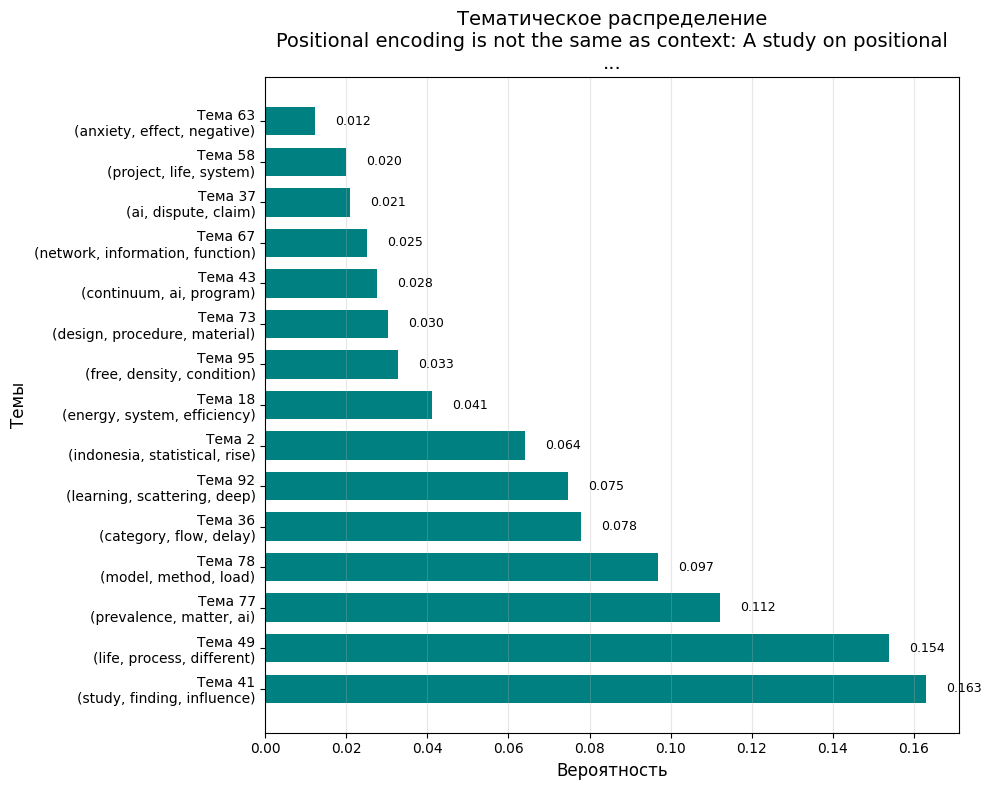

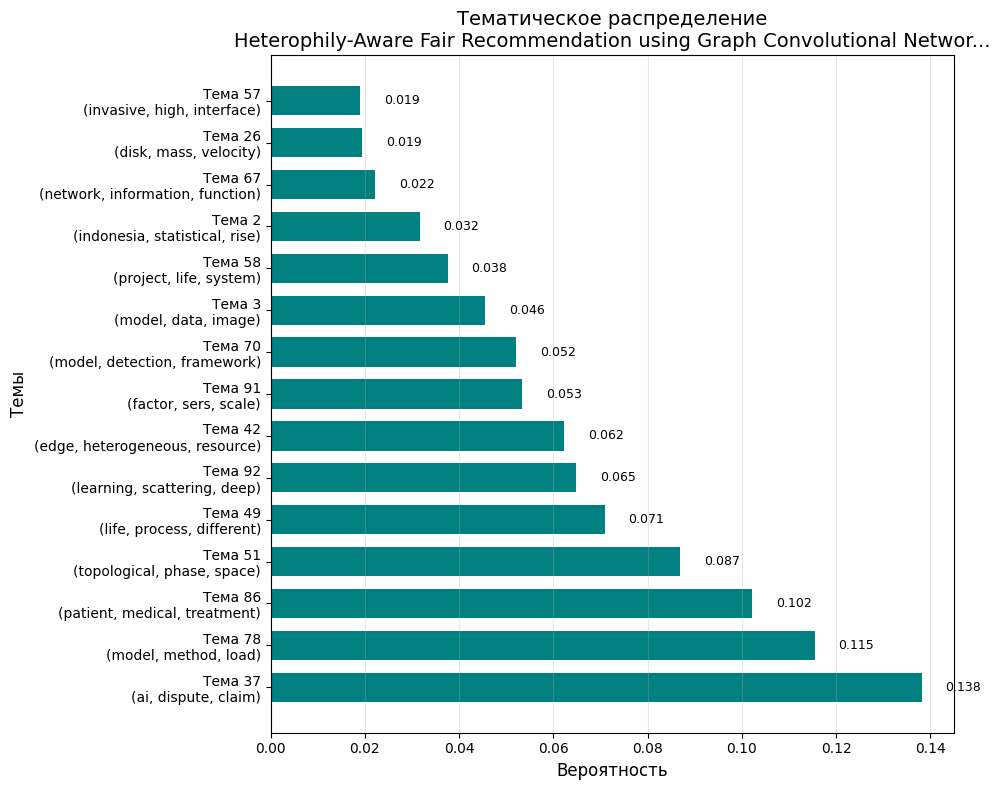

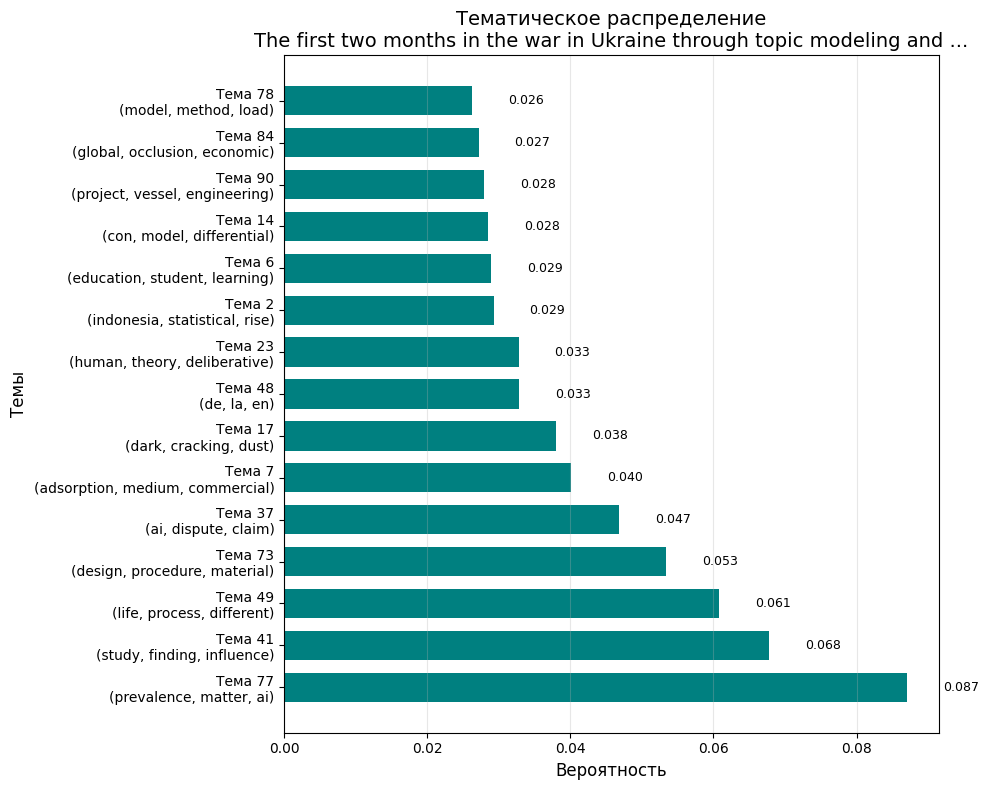

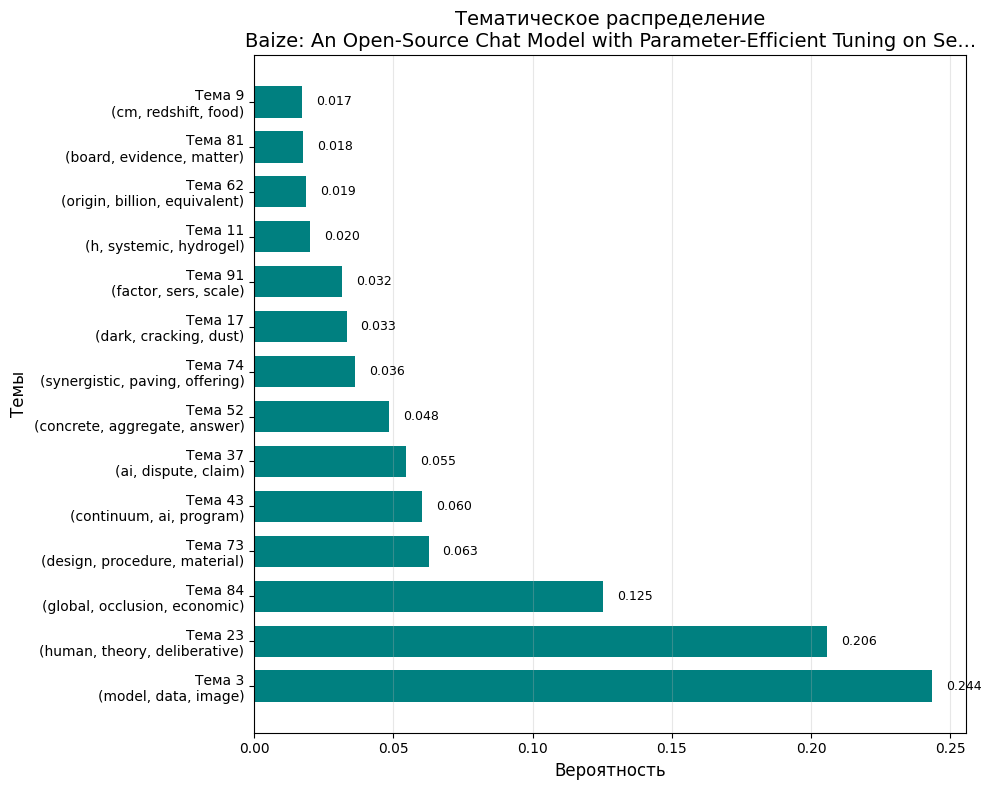

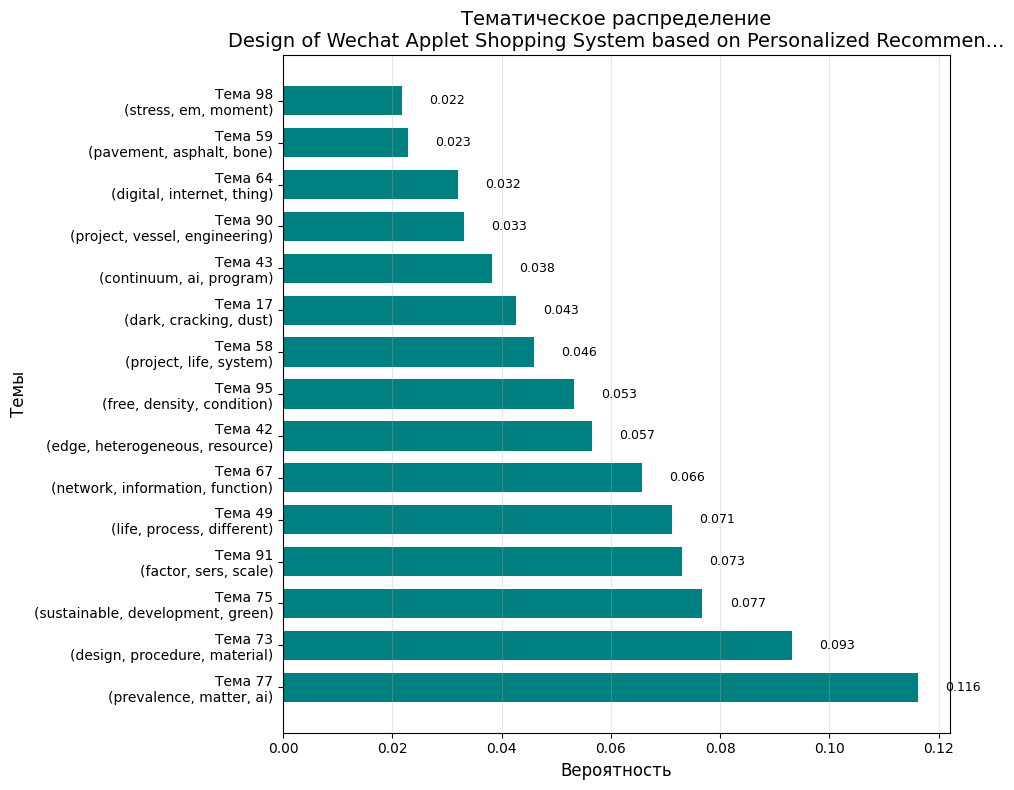

In [20]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import LdaModel

# Список статей для анализа
article_ids = [
    'W4398156663',
    'W4391631357',
    'W4316661748',
    'W4389524372',
    'W4285816353'
]

def fetch_articles(article_ids):
    """Загружает конкретные статьи по их OpenAlex ID"""
    articles = []
    
    for article_id in article_ids:
        url = f"https://api.openalex.org/works/{article_id}"
        try:
            response = requests.get(url)
            if response.status_code == 200:
                articles.append(response.json())
            else:
                print(f"Ошибка при загрузке статьи {article_id}: HTTP {response.status_code}")
        except Exception as e:
            print(f"Ошибка при загрузке статьи {article_id}: {str(e)}")
    
    return pd.DataFrame(articles)

articles_df = fetch_articles(article_ids)

# Проверяем, что статьи загружены
if articles_df.empty:
    print("Не удалось загрузить ни одной статьи")
else:
    print(f"Успешно загружено {len(articles_df)} статей")

articles_df['original_text'] = articles_df['abstract_inverted_index'].apply(undo_inverted_index)
articles_df['cleaned_text'] = articles_df['original_text'].apply(clean_text)

print("\nСтатус загрузки текста:")
for i, row in articles_df.iterrows():
    print(f"{row['id']}: {'Есть текст' if row['cleaned_text'].strip() else 'Нет текста'}")

texts = [doc.split() for doc in articles_df['cleaned_text']]
corpus = [id2word.doc2bow(text) for text in texts]

def visualize_article_topics_improved(article_row, lda_model):
    if not article_row['cleaned_text'].strip():
        print(f"Нет текста для статьи {article_row['id']}")
        return
    
    bow = id2word.doc2bow(article_row['cleaned_text'].split())
    topic_dist = lda_model.get_document_topics(bow, minimum_probability=0.01)
    
    if not topic_dist:
        print(f"Не найдено значимых тем для статьи {article_row['id']}")
        return
    
    topic_info = []
    for topic_id, prob in topic_dist:
        words = lda_model.show_topic(topic_id, topn=3)
        topic_words = ', '.join([word for word, _ in words])
        topic_info.append((topic_id, prob, topic_words))
    
    topic_info.sort(key=lambda x: x[1], reverse=True)
    
    topic_info = topic_info[:15]
    
    labels = [f"Тема {t[0]}\n({t[2]})" for t in topic_info]
    probs = [t[1] for t in topic_info]
    
    plt.figure(figsize=(10, 8))
    bars = plt.barh(labels, probs, color='teal', height=0.7)
    
    plt.xlabel('Вероятность', fontsize=12)
    plt.ylabel('Темы', fontsize=12)
    plt.title(f"Тематическое распределение\n{article_row['title'][:70]}...", fontsize=14)
    plt.grid(axis='x', alpha=0.3)
    
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', 
                ha='left', va='center',
                fontsize=9)
    
    plt.tight_layout()
    plt.show()

for _, row in articles_df.iterrows():
    visualize_article_topics_improved(row, lda)

In [21]:
data.head(20)

,id,title,cleaned_text
0,https://openalex.org/W2963305465,Building machines that learn and think like pe...,recent progress artificial intelligence renewe...
1,https://openalex.org/W2604738573,Proceedings of the 19th International Conferen...,
2,https://openalex.org/W2280321044,Applied artificial intelligence and trust—The ...,
3,https://openalex.org/W2570220393,Heading toward Artificial Intelligence 2.0,popularization internet permeation sensor netw...
4,https://openalex.org/W2528491735,Can we open the black box of AI?,artificial intelligence everywhere scientist t...
5,https://openalex.org/W2302086703,Image Captioning with Semantic Attention,automatically generating natural language desc...
6,https://openalex.org/W2558050786,Adapting to Artificial Intelligence,website us cooky enhance experience continuing...
7,https://openalex.org/W2337155942,Evolution and Revolution in Artificial Intelli...,
8,https://openalex.org/W2963920537,A Neural Algorithm of Artistic Style,fine art especially painting human mastered sk...
9,https://openalex.org/W2417517957,The new world atlas of artificial night sky br...,artificial light raise night sky luminance cre...


In [22]:
import numpy as np
from gensim.matutils import hellinger
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models import LdaModel

documents = list(data["cleaned_text"])
texts = [doc.split() for doc in documents]
id2word = Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

def get_top_topics(article_row, lda_model, num_topics=5):
    """Возвращает топ-N тем для статьи"""
    bow = id2word.doc2bow(article_row['cleaned_text'].split())
    topic_dist = lda_model.get_document_topics(bow, minimum_probability=0)
    topic_dist.sort(key=lambda x: x[1], reverse=True)
    return [(t[0], float(t[1])) for t in topic_dist[:num_topics]]

def find_unique_similar_articles(target_row, lda_model, corpus, data_df, num_similar=5):
    """Находит N наиболее похожих статей во всем корпусе"""
    target_text = target_row['cleaned_text']
    target_id = target_row['id']
    
    if not target_text.strip():
        return []
    
    # Получаем вектор тем для целевой статьи
    target_bow = id2word.doc2bow(target_text.split())
    target_topics = lda_model.get_document_topics(target_bow, minimum_probability=0)
    target_vec = np.zeros(lda_model.num_topics)
    for topic_id, prob in target_topics:
        target_vec[topic_id] = prob
    
    # Сравниваем со всем корпусом
    similarities = []
    for doc_id, doc_bow in enumerate(corpus):
        current_id = data_df.iloc[doc_id]['id']
        if current_id == target_id:  # Пропускаем оригинальную статью
            continue
            
        doc_topics = lda_model.get_document_topics(doc_bow, minimum_probability=0)
        doc_vec = np.zeros(lda_model.num_topics)
        for topic_id, prob in doc_topics:
            doc_vec[topic_id] = prob
        
        distance = hellinger(target_vec, doc_vec)
        similarities.append((doc_id, distance))
    
    # Сортируем и берем топ-N
    similarities.sort(key=lambda x: x[1])
    return [{
        'title': data_df.iloc[doc_id]['title'],
        'url': data_df.iloc[doc_id]['id'],
        'distance': f"{dist:.4f}"
    } for doc_id, dist in similarities[:num_similar]]

final_results = []

for _, row in articles_df.iterrows():
    # Получаем топ-5 тем
    top_topics = get_top_topics(row, lda)
    
    # Находим 5 наиболее похожих статей
    similar_articles = find_unique_similar_articles(row, lda, corpus, data)
    
    # Форматируем результаты
    similar_info = "\n".join([
        f"{i+1}. {art['title']}\n   Ссылка: {art['url']}\n   Расстояние: {art['distance']}"
        for i, art in enumerate(similar_articles)
    ]) if similar_articles else "Похожие статьи не найдены"
    
    final_results.append({
        'Original Title': row['title'],
        'Original URL': row['id'],
        'Top 5 Topics': "; ".join([f"Тема {t[0]}: {t[1]:.3f}" for t in top_topics]),
        'Similar Articles': similar_info
    })

for result in final_results:
    print("\n" + "="*80)
    print(f"Оригинальная статья: {result['Original Title']}")
    print(f"Ссылка: {result['Original URL']}")
    print("\nТоп-5 тематик:")
    print(result['Top 5 Topics'])
    print("\n5 наиболее похожих статей:")
    print(result['Similar Articles'])

pd.DataFrame(final_results).to_excel("final_results.xlsx", index=False)
print("\nРезультаты сохранены в final_results.xlsx")


Оригинальная статья: Positional encoding is not the same as context: A study on positional
  encoding for Sequential recommendation
Ссылка: https://openalex.org/W4398156663

Топ-5 тематик:
Тема 62: 0.101; Тема 38: 0.093; Тема 37: 0.085; Тема 77: 0.071; Тема 70: 0.069

5 наиболее похожих статей:
1. The Ethics of Emotion in Artificial Intelligence Systems
   Ссылка: https://openalex.org/W3133752603
   Расстояние: 0.5576
2. Automated Isotope Identification Algorithm Using Artificial Neural Networks
   Ссылка: https://openalex.org/W2606960612
   Расстояние: 0.5889
3. The application of artificial intelligence in public administration for forecasting high crime risk transportation areas in urban environment
   Ссылка: https://openalex.org/W2621921499
   Расстояние: 0.5913
4. Counting and classification of white blood cell using Artificial Neural Network (ANN)
   Ссылка: https://openalex.org/W2588902739
   Расстояние: 0.5914
5. Artificial Intelligence (AI) for Web Accessibility
   Ссылка: h

In [25]:
import pickle
import pandas as pd

# Подготовка данных для сохранения
model_data = {
    'model': lda,          # Ваша обученная LDA модель
    'id2word': id2word,    # Словарь
    'corpus': corpus,      # Корпус документов
    'data': pd.DataFrame({ # Создаем DataFrame с минимально необходимыми данными
        'id': [f"W{i}" for i in range(len(corpus))],  # Генерируем fake IDs если нет реальных
        'title': [f"Статья {i}" for i in range(len(corpus))]  # Заглушки для названий
    })
}

# Сохранение модели
with open('lda_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)